In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
def modelStats(actual, predict):
  return metrics.accuracy_score(actual, predict), metrics.precision_score(actual, predict), metrics.recall_score(actual, predict)

In [ ]:
full_dataset = pd.read_csv('spam_ham_dataset.csv')
full_dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# Check whether the label and label_num match up
np.sum((full_dataset['label'] == 'spam').astype(int) != full_dataset['label_num']) == 0

True

In [ ]:
# Check counts of spam and ham emails
full_dataset['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

Split into Training and Test Set

In [ ]:
# Split Dataset into training and test set
x_data, y_data = full_dataset['text'], full_dataset['label_num']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=41)
len(x_train), len(x_test)

(4653, 518)

In [ ]:
# Check how well distributed spam and ham emails are in train and test sets
prop_spam_train, prop_spam_test = y_train.value_counts().loc[1] / len(y_train) , y_test.value_counts().loc[1] / len(y_test)
print('Proportion of spam emails in training set: ', prop_spam_train)
print('Proportion of spam emails in test set: ', prop_spam_test)

Proportion of spam emails in training set:  0.28841607565011823
Proportion of spam emails in test set:  0.3030888030888031


Feature engineering

In [ ]:
# Count vectorizer used to count occurences of words in each email
cv = CountVectorizer(stop_words='english', min_df=100, max_df=4000)
cv.fit(x_train)
x_train_counts = cv.transform(x_train).toarray()
x_train_counts.shape

(4653, 455)

SVM Naive

In [ ]:
# Create naive model
model = svm.SVC(kernel='linear')
model.fit(x_train_counts, y_train)

SVC(kernel='linear')

In [ ]:
# Naive evaluation of training set training model on full training set
y_train_predict = model.predict(x_train_counts)
modelStats(y_train, y_train_predict)

(0.991833225875779, 0.9745269286754003, 0.9977645305514158)

SVM with cross validation

In [ ]:
# Pipeline model to then use to run grid search cross validation
# pipe = Pipeline([('count-vec', CountVectorizer(stop_words='english')), ('svm', svm.SVC())])
# grid = {
#     'count-vec__min_df': [30, 40, 50, 75, 100],
#     'count-vec__max_df': [3500, 4000, 4500],
#     'count-vec__binary': [True, False],
#     'svm__kernel': ['rbf', 'linear', 'sigmoid'],
#     'svm__C': [1.0, 15.0, 50.0]
# }
# grid_search = GridSearchCV(pipe, param_grid=grid)
# grid_search.fit(x_train, y_train)

In [ ]:
# grid_search.best_params_, grid_search.best_score_

In [ ]:
# Extract best model from grid search
# best_model = grid_search.best_estimator_
# best_train_predictions = best_model.predict(x_train)
# modelStats(y_train, best_train_predictions)

Uncomment above code this is just the best stuff from the grid search

In [ ]:
# filler cell
best_model = Pipeline([('count-vec', CountVectorizer(stop_words='english', max_df=3500, min_df=40)), ('svm', svm.SVC(kernel='rbf', C=50.0))])
best_model.fit(x_train, y_train)
best_train_predictions = best_model.predict(x_train)
modelStats(y_train, best_train_predictions)

(0.9926928863099076, 0.9759825327510917, 0.9992548435171386)

In [ ]:
# Evaluate test set
test_predictions = best_model.predict(x_test)
modelStats(y_test, test_predictions)

(0.9536679536679536, 0.8982035928143712, 0.9554140127388535)

PCA Analysis

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_df=3500, min_df=40)
x_train_vectorized = vectorizer.fit_transform(x_train).toarray()
x_test_vectorized = vectorizer.transform(x_test).toarray()

sc = StandardScaler()
x_train_vec_scaled = sc.fit_transform(x_train_vectorized)
x_test_vec_scaled = sc.fit_transform(x_test_vectorized)

pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_vec_scaled)

pca.explained_variance_ratio_

array([0.03967668, 0.0250512 , 0.02413683])

Text(0, 0.5, 'Explained Variance Ratio')

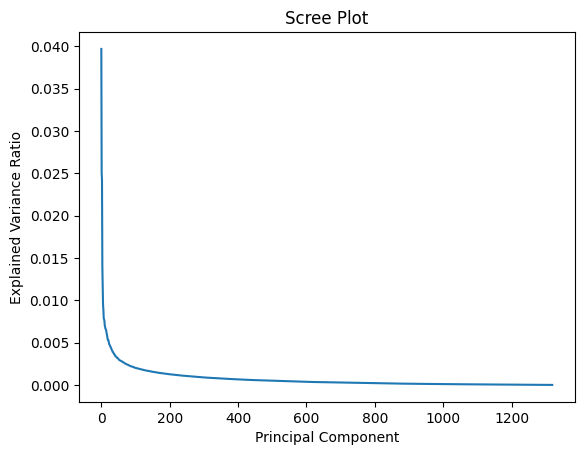

In [ ]:
pca_all = PCA()
pca_all.fit(x_train_vec_scaled)
sv_var_ratio = pca_all.explained_variance_ratio_
plt.plot(np.arange(len(sv_var_ratio)), sv_var_ratio)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

Text(0.5, 1.0, 'Training Data Projected Along PC1 and PC2')

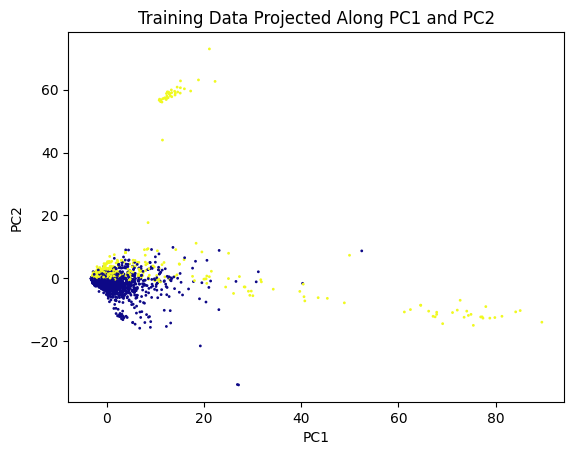

In [ ]:
plt.scatter(x_train_pca[:,0], x_train_pca[:,1], s=1, c=y_train, cmap='plasma')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Training Data Projected Along PC1 and PC2')

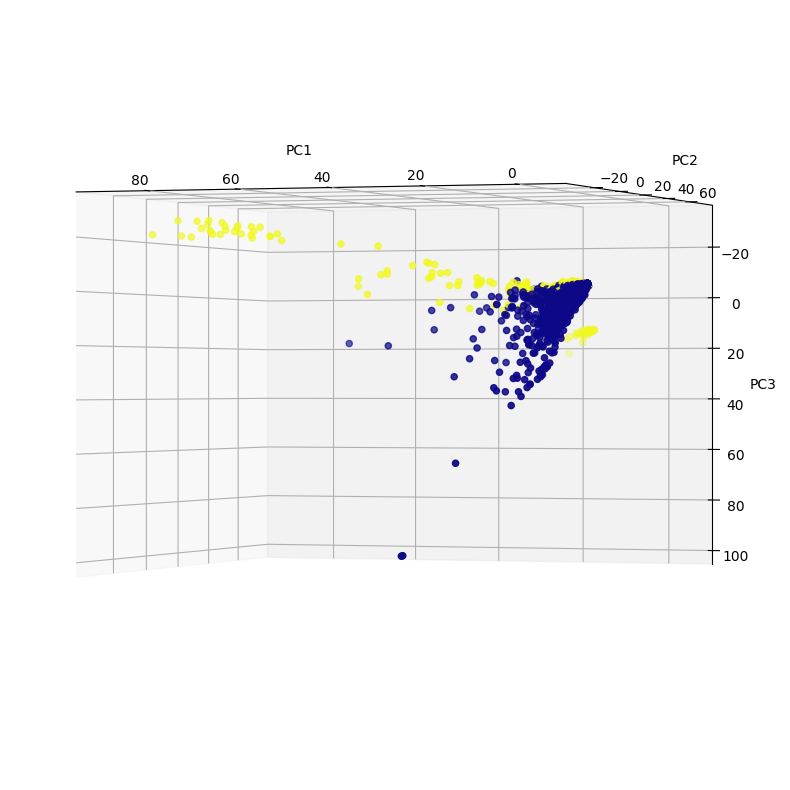

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')


# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x_train_pca[:,0],x_train_pca[:,1],x_train_pca[:,2], c=y_train,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

axis.view_init(-180,70)

In [ ]:
svm_pca = Pipeline([('pca', PCA(n_components=50)), ('svm', svm.SVC())])
svm_pca_grid = {
    'pca__n_components': [70, 80, 90, 100],
    'svm__C': [40.0, 50.0]
}
svm_pca_grid_search = GridSearchCV(svm_pca, svm_pca_grid)
svm_pca_grid_search.fit(x_train_vec_scaled, y_train)
svm_pca_grid_search.best_params_, svm_pca_grid_search.best_score_

({'pca__n_components': 80, 'svm__C': 40.0}, 0.9638929120035111)

In [ ]:
svm_pca_grid_search.cv_results_

{'mean_fit_time': array([1.59499931, 1.36757026, 1.57663803, 1.67223887, 1.51324272,
        1.7921267 , 1.91109428, 1.77166624]),
 'std_fit_time': array([0.33998986, 0.1439754 , 0.28873658, 0.30424501, 0.02759239,
        0.3342376 , 0.32620195, 0.14319067]),
 'mean_score_time': array([0.15364962, 0.11467986, 0.10205264, 0.10882592, 0.11990376,
        0.13095679, 0.13612652, 0.12892065]),
 'std_score_time': array([0.05977162, 0.02723121, 0.00244752, 0.01504931, 0.00382168,
        0.03110688, 0.02844231, 0.02749479]),
 'param_pca__n_components': masked_array(data=[70, 70, 80, 80, 90, 90, 100, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_svm__C': masked_array(data=[40.0, 50.0, 40.0, 50.0, 40.0, 50.0, 40.0, 50.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'pca__n_components': 70, 'svm__C': 4

In [ ]:
svm_pca_model = Pipeline([('pca', PCA(n_components=70)), ('svm', svm.SVC(C=50.0))])
svm_pca_model.fit(x_train_vec_scaled, y_train)

pca_test_predictions = svm_pca_model.predict(x_test_vec_scaled)
modelStats(y_test, pca_test_predictions)

(0.9478764478764479, 0.90625, 0.9235668789808917)

Logistic Regression pipelined with PCA

In [ ]:
lr_pca_model = Pipeline([('pca', PCA(n_components=70)), ('lr', linear_model.LogisticRegressionCV(cv=5, max_iter=500))])
lr_pca_model.fit(x_train_vec_scaled, y_train)

pca_train_predictions = lr_pca_model.predict(x_train_vec_scaled)
modelStats(y_train, pca_train_predictions)

(0.9649688373092629, 0.9274836838288615, 0.9530551415797317)

In [ ]:
lr_pca_cv = GridSearchCV(lr_pca_model, {'pca__n_components': [60,70,80,90,100]})
lr_pca_cv.fit(x_train_vec_scaled, y_train)
lr_pca_cv.cv_results_, lr_pca_cv.best_params_, lr_pca_cv.best_score_

({'mean_fit_time': array([5.82271028, 3.61278367, 3.47417884, 4.25339918, 4.33195724]),
  'std_fit_time': array([1.19977462, 1.0575415 , 0.44655664, 0.77545362, 0.8280011 ]),
  'mean_score_time': array([0.03018799, 0.01468849, 0.01451006, 0.01705341, 0.01395307]),
  'std_score_time': array([0.01111481, 0.00519442, 0.00360245, 0.00670411, 0.0003762 ]),
  'param_pca__n_components': masked_array(data=[60, 70, 80, 90, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'pca__n_components': 60},
   {'pca__n_components': 70},
   {'pca__n_components': 80},
   {'pca__n_components': 90},
   {'pca__n_components': 100}],
  'split0_test_score': array([0.95596133, 0.9613319 , 0.9613319 , 0.95918367, 0.96348013]),
  'split1_test_score': array([0.94629431, 0.96025779, 0.94629431, 0.95273899, 0.9538131 ]),
  'split2_test_score': array([0.9688507 , 0.96992481, 0.96992481, 0.96777658, 0.9688507 ]),
  'split3_test_score': arra

In [ ]:
lr_pca_cv_model = lr_pca_cv.best_estimator_
lr_pca_cv_predictions = lr_pca_cv_model.predict(x_test_vec_scaled)
modelStats(y_test, lr_pca_cv_predictions)

(0.9555984555984556, 0.9294871794871795, 0.9235668789808917)

Naive Logistic Regression

In [ ]:
# Create Logistic Regression model with built in cross validation
lr_model = linear_model.LogisticRegressionCV(cv=5, max_iter=500)
lr_model.fit(x_train_counts, y_train)
lr_train_predict = lr_model.predict(x_train_counts)
modelStats(y_train, lr_train_predict)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9860305179454115, 0.9577060931899641, 0.9955290611028316)

In [ ]:
# Evaluate the test set
x_test_counts = cv.transform(x_test)
lr_test_predict = lr_model.predict(x_test_counts)
modelStats(y_test, lr_test_predict)

(0.9517374517374517, 0.888235294117647, 0.9617834394904459)

Text Embedding